In [53]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.metrics import root_mean_squared_error,mean_absolute_error
import joblib

In [71]:
device = ('cuda' if torch.cuda.is_available() else 'cpu')

In [72]:
df = pd.read_csv('/content/Tesla.csv - Tesla.csv.csv',sep=',')

In [73]:
df.head()

,Date,Open,High,Low,Close,Volume,Adj Close
0,6/29/2010,19.000000,25.00,17.540001,23.889999,18766300,23.889999
1,6/30/2010,25.790001,30.42,23.299999,23.830000,17187100,23.830000
2,7/1/2010,25.000000,25.92,20.270000,21.959999,8218800,21.959999
3,7/2/2010,23.000000,23.10,18.709999,19.200001,5139800,19.200001
4,7/6/2010,20.000000,20.00,15.830000,16.110001,6866900,16.110001


In [74]:
df['Close']

,Close
0,23.889999
1,23.830000
2,21.959999
3,19.200001
4,16.110001
...,...
1687,246.169998
1688,258.000000
1689,255.729996
1690,262.049988


In [69]:
 df.shape

(1692, 7)

In [77]:
scaler = StandardScaler()
df['Close'] = scaler.fit_transform(df[['Close']])

freq = 31
data = []

for i in range(len(df) - freq):
    data.append(df.Close[i:i+freq].values.reshape(-1,1))
data = np.array(data)
train_size = int(len(data) * 0.8)

x_train = torch.from_numpy(data[:train_size,:-1,:]).type(torch.Tensor).to(device)
y_train = torch.from_numpy(data[:train_size,-1,:]).type(torch.Tensor).to(device)

x_test = torch.from_numpy(data[train_size:,:-1,:]).type(torch.Tensor).to(device)
y_test = torch.from_numpy(data[train_size:,-1,:]).type(torch.Tensor).to(device)

In [78]:
print(f"{x_train.shape}")
print(f"{y_train.shape}")
print(f"{x_test.shape}")
print(f"{y_test.shape}")

torch.Size([1328, 30, 1])
torch.Size([1328, 1])
torch.Size([333, 30, 1])
torch.Size([333, 1])


In [79]:
class LSTM(nn.Module):
  '''
  The LSTM (Long Short-Term Memory) is a model that acts like a machine
    that decides what to remember, forget, and predict based on smart gates:

    - Forget Gate: Decides what old information to forget. It uses a sigmoid activation (e.g., np.where(x > 0.5, 1, 0)).
    - Input Gate: Stores new relevant information using a sigmoid function.
    - Cell State Update: Updates the memory by combining the forget gate and input gate outputs.
    - Output Gate: Produces the final output by applying a sigmoid and tanh function on the cell state.

    Parameters:
    - input_size : Number of input data.
    - hidden_size: Number of neurons per layer.
    - num_layers: Number of LSTM layers stacked together.
    - output_size : Number of output data
  '''
  def __init__(self,input_size,hidden_size,num_layers,out_size):
    super(LSTM,self).__init__()
    self.num_layers = num_layers
    self.hidden_size = hidden_size

    self.lstm = nn.LSTM(input_size,hidden_size,num_layers,batch_first=True)
    self.fc1 = nn.Linear(hidden_size,out_size) #Fully conected
    self.dropout = nn.Dropout(0.2) #Technique to avoid overfitting in the modelby randomly "drops" (set to zero some neurons) in the network
  def forward(self,x):
    '''
    init parameters(h0,c0)
h0 = torch.zeros(num_layers, batch_size, hidden_size).to(device)
c0 = torch.zeros(num_layers, batch_size, hidden_size).to(device)

- h0: hidden state (what the model "remembers" during sequence processing)
- c0: cell state (what the model "considers important" to maintain over time)

Both h0 and c0 are initialized with zeros at the beginning (using torch.zeros()).
    '''


    h0 = torch.zeros(self.num_layers,x.size(0),self.hidden_size,device=device) #Cast on GPU
    c0 = torch.zeros(self.num_layers,x.size(0),self.hidden_size,device=device)

    out,(hn,cn) = self.lstm(x,(h0.detach(),c0.detach())) #detach from GPU// stable data for processing
    out = self.fc1(out[:,-1,:])
    return out

In [81]:
input_size = 1
hidden_size = 32
num_layers = 2
out_size = 1
model = LSTM(input_size,hidden_size,num_layers,out_size).to(device)#Cast on GPU

In [82]:
criterion = nn.MSELoss() # compares the yhat and ytrue //Better for financial data // Higher loss but more estable criterion use another if necessary RMESLOSS
optimizer = optim.Adam(model.parameters(),lr=1e-2) #weight_decay => higher (more simple the decision of the model's optimizer)

In [86]:
y_hat = None
paticience = 50
epochs = 200
   #Prediction from the model.
best_loss = float('inf') #inf => infinite number.
patience_counter = 0
model.train()
for i in range(epochs):
    y_hat = model(x_train)
    loss = criterion(y_hat,y_train)

    if i % 25 == 0 :
      rmse = torch.sqrt(loss)
      print(i,loss.item(),rmse.item())

    optimizer.zero_grad() #Starts with zero gradients
    loss.backward()  #backpropagation of the model
    optimizer.step() #Make the steps for the model loss
    if loss.item() < best_loss:
      best_loss = loss.item()
      patience_counter = 0
    else :
      patience_counter += 1

    if patience_counter >= paticience :
      print(f'{best_loss} and epoch : {i}')
      break #Breaking the train loop

0 0.9842737317085266 0.9921057224273682
25 0.031963832676410675 0.1787843257188797
50 0.006196198053658009 0.07871593534946442
75 0.004029343370348215 0.06347710639238358
100 0.0036499754060059786 0.06041502580046654
125 0.003436222206801176 0.05861929804086685
150 0.0032656139228492975 0.05714555084705353
175 0.0031074099242687225 0.055744148790836334


In [88]:
y_hat_test = None

model.eval()
with torch.no_grad():
  y_hat_test = model(x_test)
  loss = criterion(y_hat_test,y_test)
  print(loss.item())

0.004248002544045448


In [89]:
#Transforming data.Tensor into numpy arr again to rmse
if isinstance(y_hat,torch.Tensor):
  y_hat = y_hat.detach().cpu().numpy()
if isinstance(y_hat_test,torch.Tensor):
  y_hat_test = y_hat_test.detach().cpu().numpy()
if isinstance(y_train,torch.Tensor):
  y_train = y_train.detach().cpu().numpy()
if isinstance(y_test,torch.Tensor):
  y_test = y_test.detach().cpu().numpy()
#Scaler inverse transformation
y_hat = scaler.inverse_transform(y_hat)
y_hat_test = scaler.inverse_transform(y_hat_test)
y_train = scaler.inverse_transform(y_train)


In [90]:
train_rmse = root_mean_squared_error(y_train[:,0],y_hat[:,0])
print(f"{train_rmse:.2f}")
train_mae = mean_absolute_error(y_train[:,0],y_hat[:,0])

0.05


In [91]:
print(f"{train_mae:.2f}")

0.03


In [92]:
test_rmse = root_mean_squared_error(y_test[:,0],y_hat_test[:,0])
test_mae = mean_absolute_error(y_test[:,0],y_hat_test[:,0])
print(f"{test_rmse:.2f}")

0.07


In [93]:
print(f"{test_mae:.2f}")

0.05


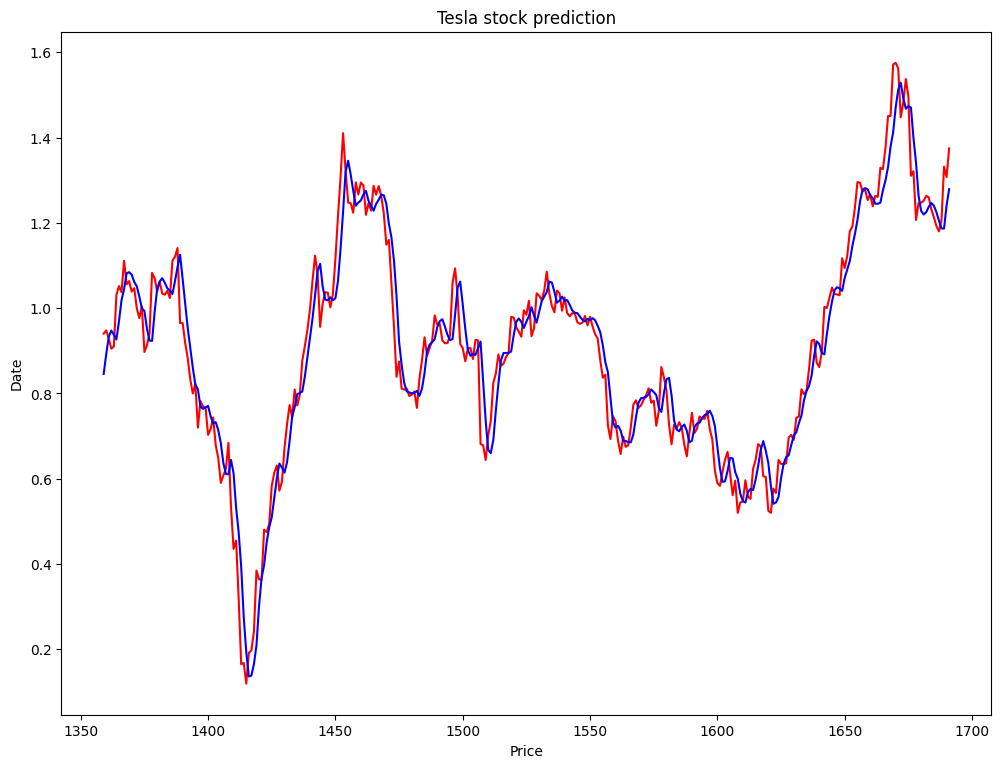

In [95]:
fig = plt.figure(figsize=(12,12))
gs = fig.add_gridspec(4,1)

ax1 = fig.add_subplot(gs[:3,0])
ax1.plot(df.iloc[-len(y_test):].index,y_test,color='red',label='Real Price')
ax1.plot(df.iloc[-len(y_test):].index,y_hat_test,color='blue',label='Predicted Price')
plt.title(f"Tesla stock prediction")
plt.xlabel('Price')
plt.ylabel('Date')
plt.show()

In [ ]:
joblib.dump("scaler.pkl",scaler)
torch.save(model.state_dict(),'model_cinemark.pth')